# defining functions with parameters

In [2]:
import pandas as pd
import gc
import torch
from datasets import Dataset
from mirage import factcc, trueTeacher, feqa, factacc, qags

def load_dataset(dataset_path):
    df = pd.read_csv(dataset_path)
    return Dataset.from_pandas(df)

def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()

def evaluate_factcc(dataset, dataset_name, source_col, gen_col, save_folder):
    clear_gpu_memory()
    
    metric = factcc()
    metric.create_pipeline(device="cuda:0")
    
    map_kwargs = {"batched": True, "batch_size": 10}
    
    return metric.evaluate_dataset(
        dataset,
        source_col=source_col,
        gen_col=gen_col,
        truncation=True,
        save_result_dataset_folder_path=save_folder,
        map_kwargs=map_kwargs
    )

def evaluate_trueTeacher(dataset, dataset_name, source_col, gen_col, save_folder):
    clear_gpu_memory()
    
    metric = trueTeacher()
    metric.create_pipeline(
        torch_dtype=torch.float16,
        device_map="auto",
        offload_folder="offload",
        max_memory={0: "22GB", 1: "22GB", "cpu": "20GB"}
    )
    
    map_kwargs = {"batched": False, "batch_size": 1}
    
    return metric.evaluate_dataset(
        dataset,
        source_col=source_col,
        gen_col=gen_col,
        truncation=True,
        save_result_dataset_folder_path=save_folder
    )

def evaluate_feqa(dataset, dataset_name, source_col, gen_col, save_folder):
    clear_gpu_memory()
    
    metric = feqa()
    metric.create_pipeline(device="cuda:0")
    
    map_kwargs = {"batched": True, "batch_size": 10}
    
    return metric.evaluate_dataset(
        dataset,
        source_col=source_col,
        gen_col=gen_col,
        keep_questions=True,
        keep_answers=True,
        qg_pipeline_call_args={"truncation":True, "max_length":512},
        save_result_dataset_folder_path=save_folder,
        map_kwargs=map_kwargs
    )

def evaluate_qags(dataset, dataset_name, source_col, gen_col, save_folder):
    clear_gpu_memory()
    
    metric = qags()
    metric.create_pipeline(device="cuda:0")
    
    map_kwargs = {"batched": True, "batch_size": 10}
    
    return metric.evaluate_dataset(
        dataset,
        source_col=source_col,
        gen_col=gen_col,
        keep_questions=True,
        keep_answers=True,
        qg_pipeline_call_args={"truncation":True, "max_length":512},
        save_result_dataset_folder_path=save_folder,
        map_kwargs=map_kwargs
    )

def evaluate_factacc(dataset, dataset_name, source_col, gen_col, save_folder):
    clear_gpu_memory()
    
    metric = factacc()
    metric.create_pipeline(device="cuda:0")

    #batched produces errors for dialfact
    map_kwargs = {"batched": False, "batch_size": 10}
    
    return metric.evaluate_dataset(
        dataset,
        source_col=source_col,
        gen_col=gen_col,
        truncation=True,
        save_result_dataset_folder_path=save_folder,
        map_kwargs=map_kwargs
    )


In [3]:
metric_functions = {
    "QAGS": evaluate_qags,
    "FactCC": evaluate_factcc,
    #"TrueTeacher": evaluate_trueTeacher,
    "FEQA": evaluate_feqa,
    "FactAcc": evaluate_factacc,
}

# Test

In [35]:
true_dataset_folder = "../../datasets/true/"
begin_dataset = true_dataset_folder + "begin_dev_download.csv"

In [36]:
data = load_dataset(begin_dataset)
data = data.select(range(10,20))
display(data[5])
display(data[9])

{'Unnamed: 0': 15,
 'grounding': 'the earliest crossbows in the world were invented in ancient china and caused a major shift in the role of projectile weaponry.',
 'previous turn': 'do you know when they started using crossbows?',
 'generated_text': "i don't think so, but the earliest crossbows in the world were invented in ancient china.",
 'gold label': 'hallucination',
 'coarse label': 'neutral',
 'full label set': 'not-generic;on-topic;uncooperative;hallucination-personal',
 'label': 0}

{'Unnamed: 0': 19,
 'grounding': 'cod is the common name for the genus "gadus" of demersal fishes, belonging to the family gadidae.',
 'previous turn': 'i am a fisherman.',
 'generated_text': "i don't own a fisherman",
 'gold label': 'generic',
 'coarse label': 'neutral',
 'full label set': 'generic;on-topic;cooperative;hallucination-personal',
 'label': 0}

In [37]:
evaluate_qags(data, "test", "grounding", "generated_text", "test_data/")

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

src_questions: [["What is the reason for people's actions, desires, and needs?"], ['What season has attracted the most viewers of any cable or broadcast television series?', 'What season has the walking dead attracted the most viewers of?'], ['What is a health insurance program that helps pay for medical expenses?', 'What is a social welfare program funded by the government?'], ['How many languages have he translated his books?'], ['How many languages have he translated his books?'], ['What was the name of the earliest crossbows in the world?', 'What was the name of the earliest crossbows invented in the world?'], ['What can be a means of transport, recreational activity or competitive winter sport?', 'What can a participant use to glide on snow?'], ['What can be a means of transport, recreational activity or competitive winter sport?', 'What can a participant use to glide on snow?'], ['What is archery used for?', 'What type of hunting has archery been used for?'], ['What is the common

Saving the dataset (0/1 shards):   0%|          | 0/10 [00:00<?, ? examples/s]

Dataset saved in Hugging Face format at test_data/


Dataset({
    features: ['Unnamed: 0', 'grounding', 'previous turn', 'generated_text', 'gold label', 'coarse label', 'full label set', 'label', 'score', 'questions', 'answers'],
    num_rows: 10
})

In [38]:
from datasets import load_from_disk
dataset = load_from_disk("test_data")

for i in range(10):
    display(dataset.select_columns(["Unnamed: 0", "grounding", "previous turn", "generated_text", "questions", "answers", "score"])[i])
    print("\n")

{'Unnamed: 0': 10,
 'grounding': "motivation is the reason for people's actions, desires, and needs.",
 'previous turn': 'i have trouble getting motivated. what about you?',
 'generated_text': "it's hard! motivation is the reason people's actions and needs are important",
 'questions': ["What is the reason for people's actions, desires, and needs?"],
 'answers': [{'generated_text': 'motivation', 'grounding': 'motivation'}],
 'score': 1.0}

{'Unnamed: 0': 11,
 'grounding': 'beginning with its third season, "the walking dead" has attracted the most 18- to 49-year-old viewers of any cable or broadcast television series.',
 'previous turn': 'wow, it has been on the air for a long time. what else can you tell me about it? i',
 'generated_text': 'the walking dead has attracted the most 18 to 49 year olds! it was a very popular show.',
 'questions': ['What season has attracted the most viewers of any cable or broadcast television series?',
  'What season has the walking dead attracted the most viewers of?'],
 'answers': [{'generated_text': 'walking dead',
   'grounding': 'the walking dead'},
  {'generated_text': '18 to 49 year olds', 'grounding': 'third season'}],
 'score': 0.4}

{'Unnamed: 0': 12,
 'grounding': 'in the united states, health insurance is any program that helps pay for medical expenses, whether through privately purchased insurance, social insurance or a social welfare program funded by the government.',
 'previous turn': 'wow, they have good services',
 'generated_text': 'well in the united states, health insurance is any program that helps pay for medical expenses.',
 'questions': ['What is a health insurance program that helps pay for medical expenses?',
  'What is a social welfare program funded by the government?'],
 'answers': [{'generated_text': 'health insurance',
   'grounding': 'privately purchased insurance, social insurance or a social welfare program funded by the government'},
  {'generated_text': 'health insurance', 'grounding': 'health insurance'}],
 'score': 0.5625}

{'Unnamed: 0': 13,
 'grounding': 'his books have been translated into 42 languages and published worldwide.',
 'previous turn': 'yes i think i have read some of his books - is he a crime writer?',
 'generated_text': "yes he's a writer and crime writer",
 'questions': ['How many languages have he translated his books?'],
 'answers': [{'generated_text': 'several', 'grounding': '42'}],
 'score': 0.0}

{'Unnamed: 0': 14,
 'grounding': 'his books have been translated into 42 languages and published worldwide.',
 'previous turn': 'yes i think i have read some of his books - is he a crime writer?',
 'generated_text': 'his books have been translated into 42 languages and published worldwide.',
 'questions': ['How many languages have he translated his books?'],
 'answers': [{'generated_text': '42', 'grounding': '42'}],
 'score': 1.0}

{'Unnamed: 0': 15,
 'grounding': 'the earliest crossbows in the world were invented in ancient china and caused a major shift in the role of projectile weaponry.',
 'previous turn': 'do you know when they started using crossbows?',
 'generated_text': "i don't think so, but the earliest crossbows in the world were invented in ancient china.",
 'questions': ['What was the name of the earliest crossbows in the world?',
  'What was the name of the earliest crossbows invented in the world?'],
 'answers': [{'generated_text': 'ancient china', 'grounding': 'ancient china'},
  {'generated_text': 'ancient china', 'grounding': 'ancient china'}],
 'score': 1.0}

{'Unnamed: 0': 16,
 'grounding': 'skiing can be a means of transport, a recreational activity or a competitive winter sport in which the participant uses skis to glide on snow.',
 'previous turn': 'try to imagine what his thoughts must have been as he is plummeting down the hill',
 'generated_text': 'he is really bad, that kind of thing is fun',
 'questions': ['What can be a means of transport, recreational activity or competitive winter sport?',
  'What can a participant use to glide on snow?'],
 'answers': [{'generated_text': 'winter sport', 'grounding': 'skiing'},
  {'generated_text': 'snow', 'grounding': 'skis'}],
 'score': 0.0}

{'Unnamed: 0': 17,
 'grounding': 'skiing can be a means of transport, a recreational activity or a competitive winter sport in which the participant uses skis to glide on snow.',
 'previous turn': 'try to imagine what his thoughts must have been as he is plummeting down the hill',
 'generated_text': 'i can imagine the joy that he was able to carry his skis down the slopes.',
 'questions': ['What can be a means of transport, recreational activity or competitive winter sport?',
  'What can a participant use to glide on snow?'],
 'answers': [{'generated_text': 'skis', 'grounding': 'skiing'},
  {'generated_text': 'skis', 'grounding': 'skis'}],
 'score': 0.5}

{'Unnamed: 0': 18,
 'grounding': 'historically, archery has been used for hunting and combat.',
 'previous turn': "wow, i have watched it a few times but i don't know much about it could you tell me more",
 'generated_text': 'well historically, archery was used for hunting and combat.',
 'questions': ['What is archery used for?',
  'What type of hunting has archery been used for?'],
 'answers': [{'generated_text': 'hunting and combat',
   'grounding': 'hunting and combat'},
  {'generated_text': 'combat', 'grounding': 'combat'}],
 'score': 1.0}

{'Unnamed: 0': 19,
 'grounding': 'cod is the common name for the genus "gadus" of demersal fishes, belonging to the family gadidae.',
 'previous turn': 'i am a fisherman.',
 'generated_text': "i don't own a fisherman",
 'questions': ['What is the common name for cod?'],
 'answers': [{'generated_text': 'cod', 'grounding': 'gadus'}],
 'score': 0.0}

# True datasets

In [4]:
true_dataset_folder = "../../datasets/true/"
dataset_dict = {
    "begin": true_dataset_folder + "begin_dev_download.csv",
    "dialfact": true_dataset_folder + "dialfact_valid_download.csv",
    "fever": true_dataset_folder + "fever_dev_download.csv",
    "mnbm": true_dataset_folder + "mnbm_download.csv",
    "q2": true_dataset_folder + "q2_download.csv",
    "qags_cnndm": true_dataset_folder + "qags_cnndm_download.csv",
    "qags_xsum": true_dataset_folder + "qags_xsum_download.csv",
    "summeval": true_dataset_folder + "summeval_download.csv", 
    "vitc": true_dataset_folder + "vitc_dev_download.csv"
}
    

In [5]:
for dataset_name, dataset_path in dataset_dict.items():
    
    data = load_dataset(dataset_path)

    display(data.to_pandas())

,Unnamed: 0,grounding,previous turn,generated_text,gold label,coarse label,full label set,label
0,0,early skiers used one long pole or spear.,i imagine it makes travel on snow much easier!...,"it is a long pole, or spear",entailment,entailment,not-generic;on-topic;uncooperative;faithful,1
1,1,"every country aims to provide basic education,...",yes before age 12. they have lasted from at le...,most countries aim to provide basic education.,entailment,entailment,not-generic;on-topic;cooperative;faithful,1
2,2,although modern skiing has evolved from beginn...,is it scary?,"yeah, it can be scary",generic,neutral,generic;on-topic;cooperative;hallucination-per...,0
3,3,although modern skiing has evolved from beginn...,is it scary?,"it has evolved from beginnings in scandinavia,...",entailment,entailment,not-generic;on-topic;uncooperative;faithful,1
4,4,popping of the kernels was achieved by hand on...,do you know how many flavours there are?,we know about a few varieties,generic,neutral,generic;on-topic;cooperative;hallucination-per...,0
...,...,...,...,...,...,...,...,...
831,831,"religious debates over the ""harry potter"" seri...",i do like some fantasy novels myself. i've nev...,j.k.rowling wrote the novels in the 1800s he a...,entailment,entailment,not-generic;on-topic;cooperative;faithful,1
832,832,almost as soon as automobiles had been invente...,that's so cool. i guess that's just our compet...,it is almost as soon as automobiles had been i...,entailment,entailment,not-generic;on-topic;uncooperative;faithful,1
833,833,"the twin albums ""use your illusion i"" and ""use...","wow, now that is impressive, what albums were ...","i think i'll have to check out the bbc album ""...",hallucination,neutral,not-generic;on-topic;cooperative;hallucination...,0
834,834,"skiing can be a means of transport, a recreati...",wow! skiing has been around that long? i guess...,"oh yeah! it's a means of transport, a recreati...",entailment,entailment,not-generic;on-topic;cooperative;faithful,1


,Unnamed: 0,grounding,generated_text,label
0,0,Physical attractiveness is the degree to which...,"Yes, it has, but what i think is just vanity t...",1
1,1,Physical attractiveness is the degree to which...,"Yes, it has, but anything you think is just va...",1
2,2,Physical attractiveness is the degree to which...,"Yes, it has, but one I think is just vanity to...",1
3,3,This has led to an interrelation of human fitn...,"Yes, it has, but some I think is just vanity t...",1
4,4,Evidence suggests that cognitive behavioral th...,It has been suggested that cognitive behaviora...,1
...,...,...,...,...
8684,8684,Red is the colour at the end of the visible sp...,Red is at the beginning of the visible spectru...,0
8685,8685,Red is the colour at the end of the visible sp...,Most people who love the color red are seen to...,0
8686,8686,The series will conclude with its eighth seaso...,"I have heard so much about Game of Thrones, I ...",1
8687,8687,The series will conclude with its eighth seaso...,The series will conclude with its eighth seaso...,0


,Unnamed: 0,id,grounding,generated_text,label
0,0,91198,Colin Kaepernick . Kaepernick began his profes...,Colin Kaepernick became a starting quarterback...,0
1,1,194462,Katherine Matilda `` Tilda '' Swinton ( born 5...,Tilda Swinton is a vegan.,0
2,2,137334,Soul Food is a 1997 American comedy-drama film...,Fox 2000 Pictures released the film Soul Food.,1
3,3,166626,"Anne Rice . Born in New Orleans , Rice spent m...",Anne Rice was born in New Jersey.,0
4,4,111897,Telemundo ( [ teleˈmundo ] ) is an American Sp...,Telemundo is a English-language television net...,0
...,...,...,...,...,...
18204,18204,17554,Amy Jade Winehouse ( 14 September 1983 -- 23 J...,Amy Winehouse died on 23 July 2011.,1
18205,18205,26217,Java . Formed mostly as the result of volcanic...,Java was formed by volcanic eruptions.,1
18206,18206,145641,Michael Hutchence . On the morning of 22 Novem...,Michael Hutchence died on a boat.,0
18207,18207,87517,"The Cyclades ( [ ˈsɪklədiːz ] Κυκλάδες , [ ci...",The Cyclades are located to the southeast of G...,1


,Unnamed: 0,bbcid,model,grounding,generated_text,label
0,0,34687720,BERTS2S,France's Dubuisson carded a 67 to tie with ove...,rory mcilroy will take a one-shot lead into th...,0
1,1,21267591,BERTS2S,Sheikh Ali Salman told the BBC that for nation...,the leader of bahrain\'s main opposition party...,1
2,2,29347895,BERTS2S,He died at his home in Cambridge following an ...,veteran classical music conductor christopher ...,0
3,3,37618111,BERTS2S,"In the year to the end of March, 57 victims of...",the number of homicides recorded by police in ...,0
4,4,37895159,BERTS2S,The Cherries went down 2-1 at Sunderland on Sa...,bournemouth manager eddie howe says his side a...,0
...,...,...,...,...,...,...
2495,2495,33721182,TranS2S,The Briton finished more than two minutes ahea...,paralympic champion sarah storey won her secon...,0
2496,2496,39017131,TranS2S,The victim was fatally injured outside a prope...,a 23-year-old man has died after a shooting ou...,0
2497,2497,40634994,TranS2S,Marcy Smith was woken up by her son David to f...,an 11-year-old boy has died in a house fire in...,0
2498,2498,35082344,TranS2S,The venture's backers include Tesla Motors and...,one of the world\'s biggest physicists has war...,0


,Unnamed: 0,model,grounding,generated_text,label
0,0,dodeca,In the gradual process of families improving t...,yes they are very well behaved . they are also...,0
1,1,memnet,In the gradual process of families improving t...,"i ' m not sure , but they ' ve been around for...",0
2,2,dodeca,Ross went from being a public-television perso...,he became famous on youtube in the 20th century .,0
3,3,memnet,Ross went from being a public-television perso...,he became popular in the 1980 ' s and 1980s .,1
4,4,dodeca,Stamp collecting proved to be an almost perfec...,stamp collecting was proven to be a perfect ho...,0
...,...,...,...,...,...
1083,1083,memnet,Dance is a performing art form consisting of p...,dance is a performing art form that involves s...,1
1084,1084,dodeca,Dance can be categorized and described by its ...,there are categories for it ' s choreography a...,1
1085,1085,memnet,Dance can be categorized and described by its ...,dance is categorized by its choreography and r...,1
1086,1086,dodeca,"Subsequently, in the new millennium, the popul...","yes , it is mostly sampling . it has also incr...",0


,Unnamed: 0,grounding,generated_text,label
0,0,Vitamin and mineral supplements are becoming m...,` the typical western diet is heavily processe...,1
1,1,England will send an under 20 team to the toul...,Aidy boothroyd will be the man in charge of th...,1
2,2,A southern iowa chiropractor accused of accept...,A chiropractor in iowa has surrendered his lic...,0
3,3,You'd have thought the celebrations would've s...,The new england patriots beat seattle seahawks...,0
4,4,"Surkhet, nepal ( cnn ) ten years ago, with her...",Nominations are open for cnn heroes 2015. Doyn...,0
...,...,...,...,...
230,230,( cnn ) did former new england patriot aaron h...,Aaron hernandez has pleaded not guilty to murd...,0
231,231,( cnn ) call it a little piece of heaven for a...,`` july 13th 2014 was the absolute worst day o...,0
232,232,Kim sears looks set to be a glowing bride afte...,Kim sears will marry her long-term partner lat...,0
233,233,David beckham's 40th birthday celebrations nex...,"David beckham's 40th birthday is on saturday, ...",0


,Unnamed: 0,grounding,generated_text,label
0,0,A g4s security van has been robbed outside a b...,Two security guards have been threatened durin...,1
1,1,London's first history day will be held on the...,Big ben's 150th anniversary has been chosen as...,0
2,2,India finished the opening day of the final te...,India's batsmen dominated the first day of the...,0
3,3,Winger dean cox says he will have to remain pa...,Former leyton orient striker dean cox says he ...,0
4,4,"A man, who downloaded thousands of images of c...",A man who admitted downloading and viewing chi...,1
...,...,...,...,...
234,234,Wales should be central in the debate on the u...,Welsh secretary stephen crabb has said wales s...,1
235,235,There has been a large increase in the number ...,The number of illegal immigrants detained or a...,0
236,236,"Fear of discrimination means 84,000 deaf and h...",Deaf people are being discriminated against at...,0
237,237,"Up to 4,000 people in wales could be affected ...",The future of bhs's pension scheme could be de...,1


,Unnamed: 0,id,grounding,generated_text,label
0,0,8764fb95bfad8ee849274873a92fb8d6b400eee2,Paul Merson has restarted his row with Andros ...,paul merson was brought on with only seven min...,0
1,1,8764fb95bfad8ee849274873a92fb8d6b400eee2,Paul Merson has restarted his row with Andros ...,paul merson has restarted his row with andros ...,1
2,2,8764fb95bfad8ee849274873a92fb8d6b400eee2,Paul Merson has restarted his row with Andros ...,paul merson has restarted his row with andros ...,1
3,3,8764fb95bfad8ee849274873a92fb8d6b400eee2,Paul Merson has restarted his row with Andros ...,paul merson has restarted his row with andros ...,1
4,4,8764fb95bfad8ee849274873a92fb8d6b400eee2,Paul Merson has restarted his row with Andros ...,paul merson has restarted his row with andros ...,1
...,...,...,...,...,...
1595,1595,e880fda4c25289f8325574246f0f8ed4ff5eb26b,A timewarp home which has remained unchanged s...,a timewarp home which has remained unchanged s...,1
1596,1596,e880fda4c25289f8325574246f0f8ed4ff5eb26b,A timewarp home which has remained unchanged s...,"The collector 's paradise in Horfield , Bristo...",1
1597,1597,e880fda4c25289f8325574246f0f8ed4ff5eb26b,A timewarp home which has remained unchanged s...,"the collector’s paradise in horfield , bristol...",1
1598,1598,e880fda4c25289f8325574246f0f8ed4ff5eb26b,A timewarp home which has remained unchanged s...,"the collector 's paradise in horfield , bristo...",1


,Unnamed: 0,id,grounding,generated_text,label
0,0,5ea2d97bc9e77c0009cda36d_1,Among the more than 512 guests and musical per...,Dragon Con had less than 1000 guests .,0
1,1,5ea2d97bc9e77c0009cda36d_2,Among the more than 6000 guests and musical pe...,Dragon Con had less than 1000 guests .,0
2,2,5ea2d97bc9e77c0009cda36d_3,Among the more than 512 guests and musical per...,Dragon Con had over 5000 guests .,0
3,3,5ea2d97bc9e77c0009cda36d_4,Among the more than 6000 guests and musical pe...,Dragon Con had over 5000 guests .,1
4,4,5ee3932bc9e77c0008cca539_1,"As of , more than cases of COVID-19 have been ...",COVID-19 has reached less than 185 countries .,0
...,...,...,...,...,...
63049,63049,5ed50881c9e77c000848ebc2_4,X-Men : Apocalypse is a 2016 American superher...,X-Men : Apocalypse is a video game .,0
63050,63050,5ed50880c9e77c000848d8ad_1,Yandex is a Russian book about specialized Int...,Yandex is only a book .,1
63051,63051,5ed50880c9e77c000848d8ad_2,Yandex -LRB- -LSB- ` yʌndɛks -RSB- Яндекс -RRB...,Yandex is only a book .,0
63052,63052,5ed50880c9e77c000848d8ad_3,Yandex -LRB- -LSB- ` yʌndɛks -RSB- Яндекс -RRB...,Yandex is a multinational technology company .,1


In [6]:
from tqdm.notebook import tqdm
import os

In [ ]:
for metric_name, metric in metric_functions.items():
    for dataset_name, dataset_path in dataset_dict.items():
        print("Processing Metric " + metric_name + " on dataset " + dataset_name )
        save_folder = "/home/benjamin/work/datasets/MIRAGE/results/true/" + dataset_name +"/" + metric_name + "/"
        if os.path.exists(save_folder) and metric_name!="QAGS":
            print("Already done")
            #continue
        data = load_dataset(dataset_path)
        
        metric(data, dataset_name, "grounding", "generated_text", save_folder)

Processing Metric QAGS on dataset begin


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/836 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Saving the dataset (0/1 shards):   0%|          | 0/836 [00:00<?, ? examples/s]

Dataset saved in Hugging Face format at /home/benjamin/work/datasets/MIRAGE/results/true/begin/QAGS/
Processing Metric QAGS on dataset dialfact


Map:   0%|          | 0/8689 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/8689 [00:00<?, ? examples/s]

Dataset saved in Hugging Face format at /home/benjamin/work/datasets/MIRAGE/results/true/dialfact/QAGS/
Processing Metric QAGS on dataset fever


Map:   0%|          | 0/18209 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18209 [00:00<?, ? examples/s]

Dataset saved in Hugging Face format at /home/benjamin/work/datasets/MIRAGE/results/true/fever/QAGS/
Processing Metric QAGS on dataset mnbm


Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

In [7]:
factcc_results = evaluate_factcc(xsumfaith_dataset, dataset_name, "document", "summary", map_kwargs_factcc, save_folder)
trueTeacher_results = evaluate_trueTeacher(xsumfaith_dataset, dataset_name, "document", "summary", map_kwargs_trueTeacher, save_folder)
feqa_results = evaluate_feqa(xsumfaith_dataset, dataset_name, "document", "summary", map_kwargs_feqa, save_folder)
factacc_results = evaluate_factacc(xsumfaith_dataset, dataset_name, "document", "summary", map_kwargs_factcc, save_folder)

# Results can be accessed as variables
print(factcc_results, trueTeacher_results, feqa_results, factacc_results)

NameError: name 'xsumfaith_dataset' is not defined

In [ ]:
import pandas as pd

df = pd.read_csv("../../datasets/true/begin_dev_download.csv")

true_dataset_folder = "../../datasets/true/"

true_dataset_dict = {
    "begin": true_dataset_folder + "begin_dev_download.csv",
    "dialfact": true_dataset_folder + "dialfact_valid_download.csv",
    "fever": true_dataset_folder + "fever_dev_download.csv",
    "mnbm": true_dataset_folder + "mnbm_download.csv",
    "q2": true_dataset_folder + "q2_download.csv",
    "qags_cnndm": true_dataset_folder + "qags_cnndm_download.csv",
    "qags_xsum": true_dataset_folder + "qags_xsum_download.csv",
    "summeval": true_dataset_folder + "summeval_download.csv",
    "vitc": true_dataset_folder + "vitc_dev_download.csv"
}

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("valhalla/t5-base-qg-hl")
model = AutoModelForSeq2SeqLM.from_pretrained("valhalla/t5-base-qg-hl")

In [ ]:
model.config.n_positions

# Results

## Test single dataset & metric

In [24]:
from pathlib import Path

def print_tree(path: Path, prefix: str = ''):
    print(prefix + path.name + ('/' if path.is_dir() else ''))
    if path.is_dir():
        children = list(path.iterdir())
        for idx, child in enumerate(sorted(children)):
            is_last = idx == len(children) - 1
            next_prefix = prefix + ('    ' if is_last else '│   ')
            branch = '└── ' if is_last else '├── '
            print_tree(child, prefix + branch)

# Example usage:
#print_tree(Path('/home/benjamin/work/datasets/MIRAGE/results/true/'))
print_tree(Path('/home/benjamin/work/github_repositories/MIRAGE/results/plots/'))


plots/
├── .ipynb_checkpoints/
├── begin/
├── ├── FEQA/
├── ├── ├── confusion_matrix.pdf
├── ├── ├── metrics_bar_chart.pdf
├── ├── ├── precision_recall_curve.pdf
├── ├── ├── roc_curve.pdf
├── ├── └── score_distribution.pdf
├── ├── FactAcc/
├── ├── ├── confusion_matrix.pdf
├── ├── ├── metrics_bar_chart.pdf
├── ├── ├── precision_recall_curve.pdf
├── ├── ├── roc_curve.pdf
├── ├── └── score_distribution.pdf
├── ├── FactCC/
├── ├── ├── confusion_matrix.pdf
├── ├── ├── metrics_bar_chart.pdf
├── ├── ├── precision_recall_curve.pdf
├── ├── ├── roc_curve.pdf
├── ├── └── score_distribution.pdf
├── └── QAGS/
├── └── ├── confusion_matrix.pdf
├── └── ├── metrics_bar_chart.pdf
├── └── ├── precision_recall_curve.pdf
├── └── ├── roc_curve.pdf
├── └── └── score_distribution.pdf
├── dialfact/
├── ├── FEQA/
├── ├── ├── confusion_matrix.pdf
├── ├── ├── metrics_bar_chart.pdf
├── ├── ├── precision_recall_curve.pdf
├── ├── ├── roc_curve.pdf
├── ├── └── score_distribution.pdf
├── ├── FactAcc/
├── ├── ├── confu

In [6]:
pip install mpld3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 3.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [8]:
from datasets import load_from_disk
from mirage import ScoreManager

dataset = load_from_disk("/home/benjamin/work/datasets/MIRAGE/results/true/summeval/FactCC")
dataset = dataset.map(lambda row: {"predictions":{"HALL": row["score"], "NOHALL": 1-row["score"]}})

#This dataset has logic inverted to our library
dataset = dataset.map(lambda row: {"label":{"NOHALL" if row["label"] else "HALL"}})

dataset[250]

{'Unnamed: 0': 250,
 'id': '03e271b4305517e02c9ead82d57327d32b99102e',
 'grounding': 'Twice French Open champion Serena Williams said her struggle to beat Sara Errani in the Fed Cup on Sunday had been a real \'eye-opener\' as the claycourt season gets into full swing. World No 1 Williams eventually prevailed 4-6 7-6(3) 6-3 against the dogged Italian to take her career record over her to 8-0 but the American was not impressed. The US  were beaten 3-2 as Williams and Alison Riske were thrashed 6-0 6-3 in the doubles rubber by Errani and Flavia Pennetta, meaning they were relegated to World Group II. American tennis star Serena Williams fought back to beat Italian Sara Errani in the Fed Cup play-off on Sunday . Tough weather conditions made it difficult for both players who had to keep on re-tossing their serves . Errani gave Williams a real scare but in the end the world No 1\'s power proved to be too much . \'Today has been a big eye opener,\' Williams said afterwards. \'I\'m totally no

In [9]:
metric_list = [
    "data_stats", "f1", "precision", "recall", "accuracy",
    "balanced_accuracy", "mcc", "kappa", "log_loss",
    "auroc", "auprc", "roc_values", "confusion_matrix", "precision_recall_values"
]
metric_list_without_values = [
    "data_stats", "f1", "precision", "recall", "accuracy",
    "balanced_accuracy", "mcc", "kappa", "log_loss",
    "auroc", "auprc", "confusion_matrix"
]

score_manager = ScoreManager(dataset, metric_list=metric_list_without_values)


# View metrics
display(score_manager.results)

{'data_stats': {'total_samples': 1600,
  'pos_count': 294,
  'neg_count': 1306,
  'pos_ratio': 0.18375,
  'neg_ratio': 0.81625,
  'mean_score': 0.3590182378063014,
  'std_score': 0.4552094161573908},
 'f1': np.float64(0.7298600379929493),
 'precision': np.float64(0.7986115058324497),
 'recall': np.float64(0.699375),
 'accuracy': 0.699375,
 'balanced_accuracy': np.float64(0.6840667354231126),
 'mcc': np.float64(0.2971356110137876),
 'kappa': np.float64(0.268649624631759),
 'log_loss': 1.532389884192878,
 'auroc': np.float64(0.7606728755820859),
 'auprc': np.float64(0.37180241868115116),
 'confusion_matrix': array([[194, 100],
        [381, 925]])}

Plot saved: results/plots/score_distribution.pdf


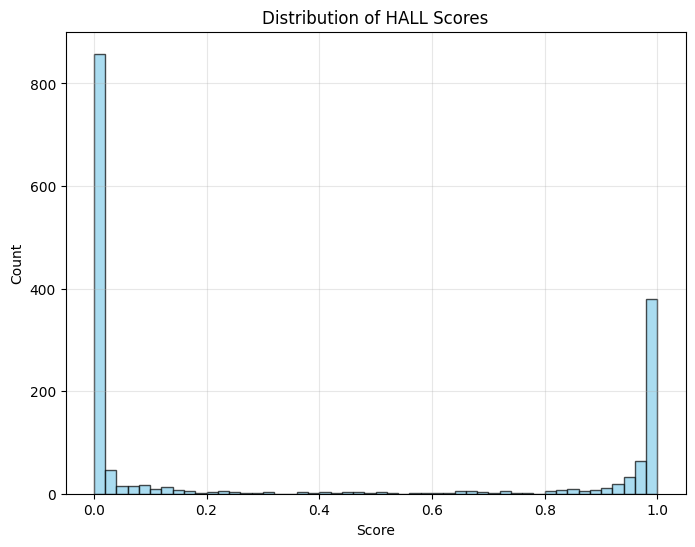

Plot saved: results/plots/metrics_bar.pdf


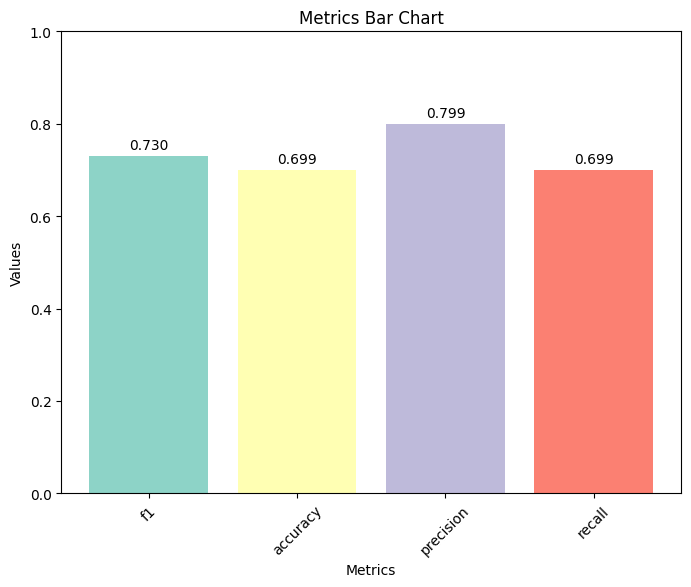

Plot saved: results/plots/roc_curve.pdf


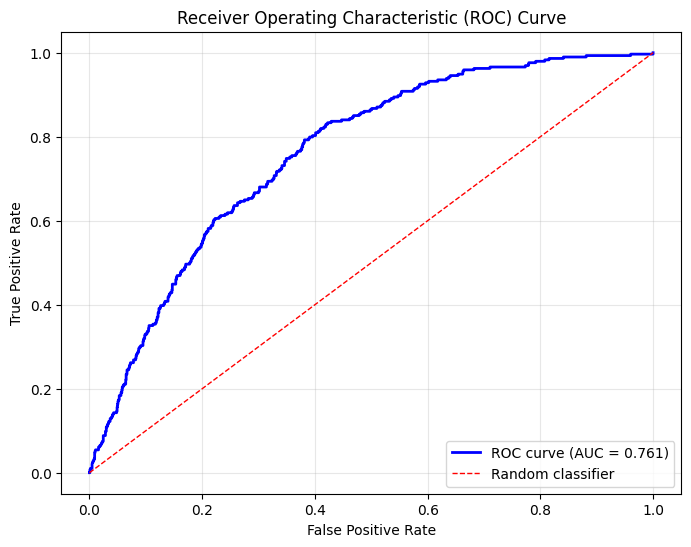

Plot saved: results/plots/precision_recall_curve.pdf


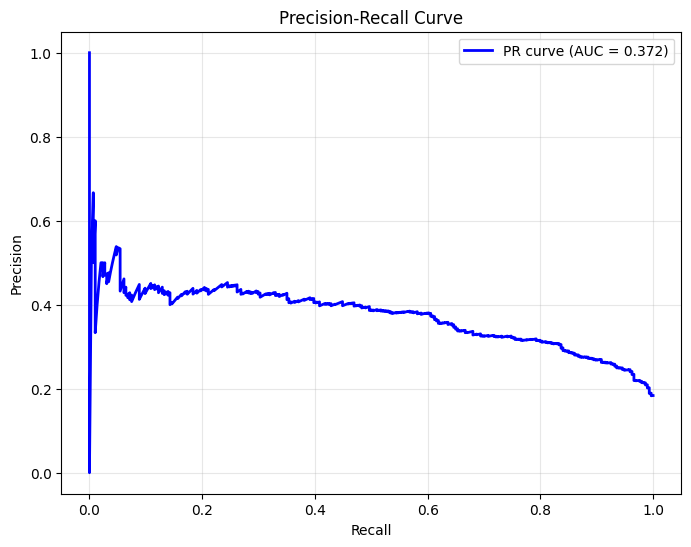

Plot saved: results/plots/confusion_matrix.pdf


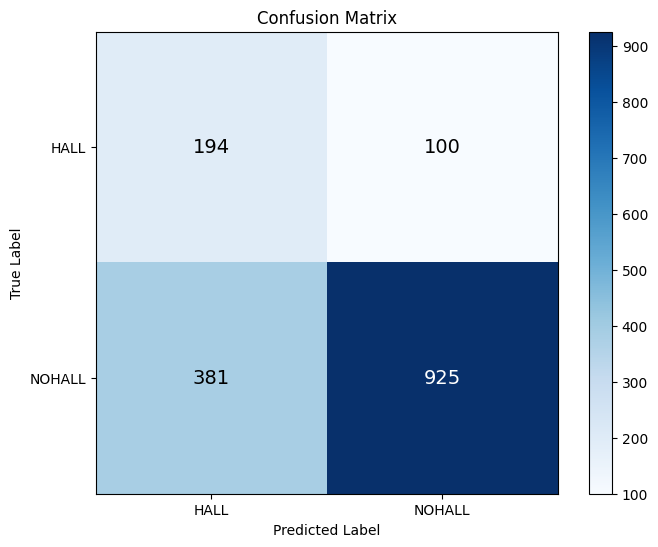

In [10]:
# Plot key metrics
score_manager.plot(
    plot_list=["score_distribution", "metrics_bar", "roc_curve", "precision_recall_curve", "confusion_matrix"],
    metrics_bar=["f1", "accuracy", "precision", "recall"],
    save_plots=True,
    save_format='pdf',
    output_path="results/plots",
    interactive=False
)

In [13]:
score_manager.plot(['roc_curve', 'precision_recall_curve', 'confusion_matrix'], 
                   interactive=True,           # Use Plotly
                   save_plots=True,
                   show_plots=False,          # Just save, don't display
                   save_format="png",        # Interactive HTML
                   output_path='plots/')

Plot saved: plots/roc_curve.png
Plot saved: plots/precision_recall_curve.png
Plot saved: plots/confusion_matrix.png


Combined plot saved to: plots/plots.pdf


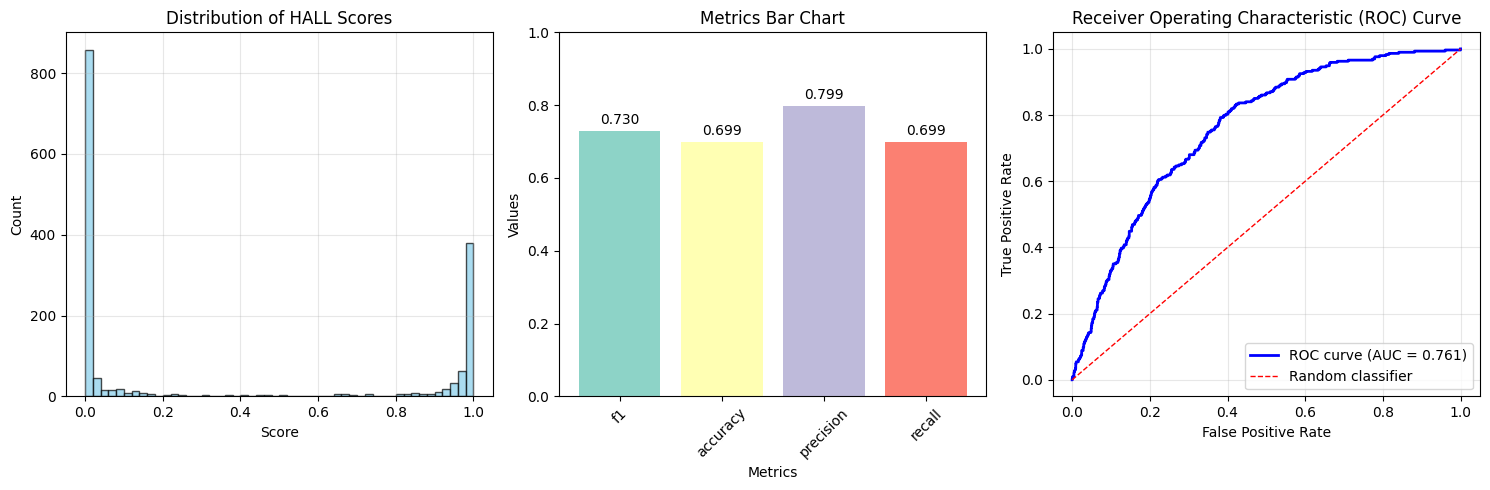

In [14]:
score_manager.combined_plots(
    plot_list=["score_distribution", "metrics_bar", "roc_curve"],
    save_path="plots/plots.pdf", figsize=(15, 5)
)

## Process all

In [ ]:
import os
import json
from datasets import load_from_disk
from mirage import ScoreManager
from tqdm.notebook import tqdm

# Define your root directory
root_dir = "/home/benjamin/work/datasets/MIRAGE/results/true"

# Define the list of metrics to compute
metric_list = [
    "data_stats", "f1", "precision", "recall", "accuracy",
    "balanced_accuracy", "mcc", "kappa", "log_loss",
    "auroc", "auprc", "roc_values", "confusion_matrix", "precision_recall_values"
]

# Prepare a container for results
all_results = {}

# Output path for plots
plots_root = "results/plots"

# Walk through each dataset (e.g., begin, fever, dialfact...)
for dataset_name in tqdm(os.listdir(root_dir)):
    dataset_path = os.path.join(root_dir, dataset_name)
    if not os.path.isdir(dataset_path):
        continue

    all_results[dataset_name] = {}

    # Each subfolder is a metric result (e.g., FEQA, FactAcc, etc.)
    for metric_dir in os.listdir(dataset_path):
        metric_path = os.path.join(dataset_path, metric_dir)
        if not os.path.isdir(metric_path):
            continue

        try:
            # Load the dataset
            dataset = load_from_disk(metric_path)

            # Invert prediction logic
            dataset = dataset.map(lambda row: {"predictions": {"HALL": row["score"], "NOHALL": 1 - row["score"]}})
            dataset = dataset.map(lambda row: {"label": "NOHALL" if row["label"] else "HALL"})

            # Score it
            score_manager = ScoreManager(dataset, metric_list=metric_list, on_split="test")

            # Save results
            all_results[dataset_name][metric_dir] = score_manager.results

            # Output directory for plots
            output_dir = os.path.join(plots_root, dataset_name, metric_dir)
            os.makedirs(output_dir, exist_ok=True)

            # Save plots
            score_manager.plot(
                plot_list=["score_distribution", "metrics_bar", "roc_curve", "precision_recall_curve", "confusion_matrix"],
                metrics_bar=["f1", "accuracy", "precision", "recall"],
                save_plots=True,
                save_format='pdf',
                output_path=output_dir,
                interactive=True
            )

            print(f"✅ Processed {dataset_name}/{metric_dir}")

        except Exception as e:
            print(f"❌ Failed to process {dataset_name}/{metric_dir}: {e}")

# Optionally, save results as JSON
os.makedirs("results", exist_ok=True)
with open("results/all_results.json", "w") as f:
    json.dump(all_results, f, indent=2, default=str)


In [7]:
import json
import pandas as pd

# Load the results
with open("results/all_results.json", "r") as f:
    results = json.load(f)

# Let's process the structure into a flat dictionary first
flat_data = {}

# Loop through outer keys like 'qags_xsum'
for dataset_key, dataset_val in results.items():
    for model_key, model_val in dataset_val.items():
        metrics = model_val.copy()
        # Remove nested dicts like data_stats, roc_values, etc.
        for subkey in ['data_stats', 'roc_values', 'confusion_matrix', 'precision_recall_values']:
            metrics.pop(subkey, None)
        # Create label for the column
        col_label = f"{dataset_key}/{model_key}"
        flat_data[col_label] = metrics

# Convert to DataFrame
df = pd.DataFrame(flat_data)

# Display the DataFrame
df


,qags_xsum/QAGS,qags_xsum/FEQA,qags_xsum/FactCC,qags_xsum/FactAcc,fever/QAGS,fever/FEQA,fever/FactCC,fever/FactAcc,dialfact/QAGS,dialfact/FEQA,...,mnbm/FactCC,mnbm/FactAcc,vitc/QAGS,vitc/FEQA,vitc/FactCC,vitc/FactAcc,q2/QAGS,q2/FEQA,q2/FactCC,q2/FactAcc
f1,0.428897,0.317190,0.644389,0.333474,0.473116,0.258392,0.587784,0.241277,0.328005,0.267919,...,0.789032,0.018882,0.438211,0.465931,0.542972,0.345202,0.441869,0.492847,0.601647,0.425459
precision,0.539170,0.235570,0.644449,0.579604,0.531822,0.470507,0.623500,0.430574,0.394890,0.348694,...,0.834973,0.010404,0.452198,0.507520,0.548630,0.371967,0.434927,0.501808,0.602291,0.420384
recall,0.506276,0.485356,0.644351,0.489540,0.464605,0.358504,0.578231,0.348070,0.352860,0.338474,...,0.754800,0.102000,0.459051,0.504948,0.547039,0.465791,0.496324,0.540441,0.601103,0.557904
accuracy,0.506276,0.485356,0.644351,0.489540,0.464605,0.358504,0.578231,0.348070,0.352860,0.338474,...,0.754800,0.102000,0.459051,0.504948,0.547039,0.465791,0.496324,0.540441,0.601103,0.557904
balanced_accuracy,0.517136,0.500000,0.644169,0.503820,0.487211,0.478540,0.586715,0.469675,0.399817,0.412000,...,0.561051,0.500000,0.459314,0.505317,0.546910,0.466377,0.446801,0.492869,0.592814,0.485606
mcc,0.050982,0.000000,0.288277,0.034295,-0.024733,-0.071385,0.165563,-0.105135,-0.218654,-0.232754,...,0.091047,0.000000,-0.088179,0.012641,0.095537,-0.131147,-0.134663,-0.017852,0.185122,-0.078461
kappa,0.033516,0.000000,0.288267,0.007421,-0.022252,-0.031444,0.157797,-0.044267,-0.171713,-0.144071,...,0.083597,0.000000,-0.081330,0.010626,0.093845,-0.067168,-0.114954,-0.015380,0.185089,-0.032824
log_loss,6.675513,0.960764,2.044461,18.398852,10.871104,1.566644,1.762536,22.870554,15.200558,6.093789,...,1.051474,32.367201,11.365338,4.324380,2.119059,19.107750,10.359942,4.936436,2.050199,15.805785
auroc,0.553687,0.502874,0.649530,0.503820,0.479974,0.441817,0.618696,0.464711,0.365465,0.275226,...,0.593278,0.500000,0.445287,0.500847,0.563071,0.465365,0.426257,0.497795,0.636898,0.485610
auprc,0.576649,0.514470,0.641082,0.594601,0.669364,0.603810,0.759224,0.572780,0.537782,0.485261,...,0.913838,0.949000,0.487083,0.506214,0.545035,0.376334,0.376307,0.413087,0.545802,0.323687


In [8]:
[i.lower() for i in ["CONFUSION_MATRIX", "PRECISION_RECALL_VALUES", "ROC_VALUES", "DATA_STATS"]]

['confusion_matrix', 'precision_recall_values', 'roc_values', 'data_stats']

In [9]:
import pandas as pd

def display_metric_tables_by_dataset(results_dict):
    skip_metrics = {'confusion_matrix', 'precision_recall_values', 'roc_values', 'data_stats'}
    datasets = list(results_dict.keys())

    # Collect all methods and metrics
    methods = set()
    metrics = set()

    for ds, method_dict in results_dict.items():
        for method, metric_dict in method_dict.items():
            if method == "data_stats":
                continue
            methods.add(method)
            metrics.update(m for m in metric_dict if m not in skip_metrics)

    methods = sorted(methods)
    metrics = sorted(metrics)

    for metric in metrics:
        data_rows = []
        for ds in datasets:
            ds_entry = results_dict[ds]
            
            stats = ds_entry["QAGS"]["data_stats"]
            
            row = {
                "pos_count": stats.get("pos_count"),
                "neg_count": stats.get("neg_count"),
                "pos_ratio": round(stats.get("pos_ratio", 0), 4),
                "neg_ratio": round(stats.get("neg_ratio", 0), 4),
            }
            for method in methods:
                val = ds_entry.get(method, {}).get(metric, None)
                row[method] = round(val, 4) if isinstance(val, float) else val
            data_rows.append(row)

        df = pd.DataFrame(data_rows)
        df.insert(0, "Dataset", datasets)
        print(f"\n=== {metric.upper()} TABLE ===")
        display(df)  # If you're not using Jupyter, use print(df.to_string()) instead


In [10]:
display_metric_tables_by_dataset(results)



=== ACCURACY TABLE ===


,Dataset,pos_count,neg_count,pos_ratio,neg_ratio,FEQA,FactAcc,FactCC,QAGS
0,qags_xsum,123,116,0.5146,0.4854,0.4854,0.4895,0.6444,0.5063
1,fever,11816,6393,0.6489,0.3511,0.3585,0.3481,0.5782,0.4646
2,dialfact,5348,3341,0.6155,0.3845,0.3385,0.3656,0.5342,0.3529
3,qags_cnndm,122,113,0.5191,0.4809,0.4809,0.5064,0.6979,0.4383
4,summeval,294,1306,0.1837,0.8163,0.8163,0.8037,0.6994,0.7025
5,begin,554,282,0.6627,0.3373,0.2440,0.2727,0.5048,0.3014
6,mnbm,2245,255,0.8980,0.1020,0.1112,0.1020,0.7548,0.1104
7,vitc,31570,31484,0.5007,0.4993,0.5049,0.4658,0.5470,0.4591
8,q2,460,628,0.4228,0.5772,0.5404,0.5579,0.6011,0.4963



=== AUPRC TABLE ===


,Dataset,pos_count,neg_count,pos_ratio,neg_ratio,FEQA,FactAcc,FactCC,QAGS
0,qags_xsum,123,116,0.5146,0.4854,0.5145,0.5946,0.6411,0.5766
1,fever,11816,6393,0.6489,0.3511,0.6038,0.5728,0.7592,0.6694
2,dialfact,5348,3341,0.6155,0.3845,0.4853,0.4905,0.6612,0.5378
3,qags_cnndm,122,113,0.5191,0.4809,0.4652,0.6158,0.7479,0.4705
4,summeval,294,1306,0.1837,0.8163,0.1765,0.1834,0.3718,0.1929
5,begin,554,282,0.6627,0.3373,0.4954,0.4637,0.7299,0.5570
6,mnbm,2245,255,0.8980,0.1020,0.9068,0.9490,0.9138,0.8896
7,vitc,31570,31484,0.5007,0.4993,0.5062,0.3763,0.5450,0.4871
8,q2,460,628,0.4228,0.5772,0.4131,0.3237,0.5458,0.3763



=== AUROC TABLE ===


,Dataset,pos_count,neg_count,pos_ratio,neg_ratio,FEQA,FactAcc,FactCC,QAGS
0,qags_xsum,123,116,0.5146,0.4854,0.5029,0.5038,0.6495,0.5537
1,fever,11816,6393,0.6489,0.3511,0.4418,0.4647,0.6187,0.4800
2,dialfact,5348,3341,0.6155,0.3845,0.2752,0.4613,0.5539,0.3655
3,qags_cnndm,122,113,0.5191,0.4809,0.4430,0.5259,0.7634,0.4016
4,summeval,294,1306,0.1837,0.8163,0.4728,0.4996,0.7607,0.4553
5,begin,554,282,0.6627,0.3373,0.1818,0.3805,0.6413,0.2880
6,mnbm,2245,255,0.8980,0.1020,0.5142,0.5000,0.5933,0.4796
7,vitc,31570,31484,0.5007,0.4993,0.5008,0.4654,0.5631,0.4453
8,q2,460,628,0.4228,0.5772,0.4978,0.4856,0.6369,0.4263



=== BALANCED_ACCURACY TABLE ===


,Dataset,pos_count,neg_count,pos_ratio,neg_ratio,FEQA,FactAcc,FactCC,QAGS
0,qags_xsum,123,116,0.5146,0.4854,0.5000,0.5038,0.6442,0.5171
1,fever,11816,6393,0.6489,0.3511,0.4785,0.4697,0.5867,0.4872
2,dialfact,5348,3341,0.6155,0.3845,0.4120,0.4619,0.5501,0.3998
3,qags_cnndm,122,113,0.5191,0.4809,0.5000,0.5223,0.6963,0.4411
4,summeval,294,1306,0.1837,0.8163,0.5000,0.5003,0.6841,0.4870
5,begin,554,282,0.6627,0.3373,0.3086,0.3808,0.5759,0.3467
6,mnbm,2245,255,0.8980,0.1020,0.5034,0.5000,0.5611,0.4995
7,vitc,31570,31484,0.5007,0.4993,0.5053,0.4664,0.5469,0.4593
8,q2,460,628,0.4228,0.5772,0.4929,0.4856,0.5928,0.4468



=== F1 TABLE ===


,Dataset,pos_count,neg_count,pos_ratio,neg_ratio,FEQA,FactAcc,FactCC,QAGS
0,qags_xsum,123,116,0.5146,0.4854,0.3172,0.3335,0.6444,0.4289
1,fever,11816,6393,0.6489,0.3511,0.2584,0.2413,0.5878,0.4731
2,dialfact,5348,3341,0.6155,0.3845,0.2679,0.2478,0.5389,0.3280
3,qags_cnndm,122,113,0.5191,0.4809,0.3123,0.4058,0.6973,0.4354
4,summeval,294,1306,0.1837,0.8163,0.7337,0.7338,0.7299,0.6971
5,begin,554,282,0.6627,0.3373,0.2123,0.1883,0.4993,0.2950
6,mnbm,2245,255,0.8980,0.1020,0.0380,0.0189,0.7890,0.0378
7,vitc,31570,31484,0.5007,0.4993,0.4659,0.3452,0.5430,0.4382
8,q2,460,628,0.4228,0.5772,0.4928,0.4255,0.6016,0.4419



=== KAPPA TABLE ===


,Dataset,pos_count,neg_count,pos_ratio,neg_ratio,FEQA,FactAcc,FactCC,QAGS
0,qags_xsum,123,116,0.5146,0.4854,0.0000,0.0074,0.2883,0.0335
1,fever,11816,6393,0.6489,0.3511,-0.0314,-0.0443,0.1578,-0.0223
2,dialfact,5348,3341,0.6155,0.3845,-0.1441,-0.0602,0.0925,-0.1717
3,qags_cnndm,122,113,0.5191,0.4809,0.0000,0.0432,0.3935,-0.1170
4,summeval,294,1306,0.1837,0.8163,0.0000,0.0008,0.2686,-0.0269
5,begin,554,282,0.6627,0.3373,-0.2926,-0.1718,0.1205,-0.2441
6,mnbm,2245,255,0.8980,0.1020,0.0014,0.0000,0.0836,-0.0002
7,vitc,31570,31484,0.5007,0.4993,0.0106,-0.0672,0.0938,-0.0813
8,q2,460,628,0.4228,0.5772,-0.0154,-0.0328,0.1851,-0.1150



=== LOG_LOSS TABLE ===


,Dataset,pos_count,neg_count,pos_ratio,neg_ratio,FEQA,FactAcc,FactCC,QAGS
0,qags_xsum,123,116,0.5146,0.4854,0.9608,18.3989,2.0445,6.6755
1,fever,11816,6393,0.6489,0.3511,1.5666,22.8706,1.7625,10.8711
2,dialfact,5348,3341,0.6155,0.3845,6.0938,22.6967,2.3649,15.2006
3,qags_cnndm,122,113,0.5191,0.4809,0.9610,17.6448,1.3885,8.5802
4,summeval,294,1306,0.1837,0.8163,0.5135,6.9636,1.5324,3.8587
5,begin,554,282,0.6627,0.3373,6.6871,26.2144,2.3694,16.5657
6,mnbm,2245,255,0.8980,0.1020,1.4500,32.3672,1.0515,21.4416
7,vitc,31570,31484,0.5007,0.4993,4.3244,19.1078,2.1191,11.3653
8,q2,460,628,0.4228,0.5772,4.9364,15.8058,2.0502,10.3599



=== MCC TABLE ===


,Dataset,pos_count,neg_count,pos_ratio,neg_ratio,FEQA,FactAcc,FactCC,QAGS
0,qags_xsum,123,116,0.5146,0.4854,0.0000,0.0343,0.2883,0.0510
1,fever,11816,6393,0.6489,0.3511,-0.0714,-0.1051,0.1656,-0.0247
2,dialfact,5348,3341,0.6155,0.3845,-0.2328,-0.1412,0.0982,-0.2187
3,qags_cnndm,122,113,0.5191,0.4809,0.0000,0.0799,0.3942,-0.1191
4,summeval,294,1306,0.1837,0.8163,0.0000,0.0014,0.2971,-0.0270
5,begin,554,282,0.6627,0.3373,-0.4242,-0.3362,0.1556,-0.3132
6,mnbm,2245,255,0.8980,0.1020,0.0206,0.0000,0.0910,-0.0031
7,vitc,31570,31484,0.5007,0.4993,0.0126,-0.1311,0.0955,-0.0882
8,q2,460,628,0.4228,0.5772,-0.0179,-0.0785,0.1851,-0.1347



=== PRECISION TABLE ===


,Dataset,pos_count,neg_count,pos_ratio,neg_ratio,FEQA,FactAcc,FactCC,QAGS
0,qags_xsum,123,116,0.5146,0.4854,0.2356,0.5796,0.6444,0.5392
1,fever,11816,6393,0.6489,0.3511,0.4705,0.4306,0.6235,0.5318
2,dialfact,5348,3341,0.6155,0.3845,0.3487,0.3700,0.5760,0.3949
3,qags_cnndm,122,113,0.5191,0.4809,0.2312,0.5745,0.6979,0.4402
4,summeval,294,1306,0.1837,0.8163,0.6663,0.7008,0.7986,0.6919
5,begin,554,282,0.6627,0.3373,0.2780,0.2588,0.6428,0.3733
6,mnbm,2245,255,0.8980,0.1020,0.8725,0.0104,0.8350,0.8086
7,vitc,31570,31484,0.5007,0.4993,0.5075,0.3720,0.5486,0.4522
8,q2,460,628,0.4228,0.5772,0.5018,0.4204,0.6023,0.4349



=== RECALL TABLE ===


,Dataset,pos_count,neg_count,pos_ratio,neg_ratio,FEQA,FactAcc,FactCC,QAGS
0,qags_xsum,123,116,0.5146,0.4854,0.4854,0.4895,0.6444,0.5063
1,fever,11816,6393,0.6489,0.3511,0.3585,0.3481,0.5782,0.4646
2,dialfact,5348,3341,0.6155,0.3845,0.3385,0.3656,0.5342,0.3529
3,qags_cnndm,122,113,0.5191,0.4809,0.4809,0.5064,0.6979,0.4383
4,summeval,294,1306,0.1837,0.8163,0.8163,0.8037,0.6994,0.7025
5,begin,554,282,0.6627,0.3373,0.2440,0.2727,0.5048,0.3014
6,mnbm,2245,255,0.8980,0.1020,0.1112,0.1020,0.7548,0.1104
7,vitc,31570,31484,0.5007,0.4993,0.5049,0.4658,0.5470,0.4591
8,q2,460,628,0.4228,0.5772,0.5404,0.5579,0.6011,0.4963


In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import math


def make_confusion_matrix_grid(root_dir="plots", save_path="confusion_matrix_grid.pdf"):
    datasets = sorted([
        d for d in os.listdir(root_dir)
        if os.path.isdir(os.path.join(root_dir, d)) and not d.startswith(".")
    ])

    # Get all unique methods from first dataset (assumes consistent structure)
    first_dataset_path = os.path.join(root_dir, datasets[0])
    methods = sorted([
        m for m in os.listdir(first_dataset_path)
        if os.path.isdir(os.path.join(first_dataset_path, m)) and not m.startswith(".")
    ])

    n_rows = len(datasets)
    n_cols = len(methods)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

    for i, dataset in enumerate(datasets):
        for j, method in enumerate(methods):
            ax = axes[i][j] if n_rows > 1 else (axes[j] if n_cols > 1 else axes)

            pdf_path = os.path.join(root_dir, dataset, method, "confusion_matrix.pdf")
            ax.axis('off')

            if os.path.exists(pdf_path):
                try:
                    doc = fitz.open(pdf_path)
                    pix = doc.load_page(0).get_pixmap(dpi=150)
                    ax.imshow(pix.tobytes("ppm"), format="ppm")
                except Exception as e:
                    print(f"Error loading {pdf_path}: {e}")
                    ax.text(0.5, 0.5, "Error", ha='center', va='center')
            else:
                ax.text(0.5, 0.5, "Missing", ha='center', va='center', fontsize=12)

            if i == 0:
                ax.set_title(method, fontsize=10)
            if j == 0:
                ax.set_ylabel(dataset, fontsize=10)

    plt.tight_layout()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)
    plt.close()